for one light curve, 3 obs in two fitlters; > 5sigma;

all combination of time gaps, observations;



one light curve, multiple combinations

f1 f2 f3

total number of events



In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lsst.sims.maf.db as db
from lsst.sims.maf.utils import m52snr
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.plots as plots

import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
from lsst.sims.utils import equatorialFromGalactic, hpid2RaDec, _healbin, healbin
from lsst.utils import getPackageDir
#from mafContrib import KN_lc, KNePopMetric, generateKNPopSlicer
import healpy as hp
import os

import glob    
from itertools import combinations
import pickle
import time
#from lsst.sims.utils import uniformSphere
#from lsst.sims.photUtils import Dust_values

In [2]:
hp.nside2pixarea?

Signature: hp.nside2pixarea(nside, degrees=False)
Docstring:
Give pixel area given nside in square radians or square degrees.

Parameters
----------
nside : int
  healpix nside parameter, must be a power of 2, less than 2**30
degrees : bool
  if True, returns pixel area in square degrees, in square radians otherwise

Returns
-------
pixarea : float
  pixel area in square radian or square degree

Notes
-----
Raise a ValueError exception if nside is not valid.

Examples
--------
>>> import healpy as hp
>>> hp.nside2pixarea(128, degrees = True)  # doctest: +FLOAT_CMP
0.2098234113027917

>>> hp.nside2pixarea(256)
1.5978966540475428e-05

>>> hp.nside2pixarea(7)
0.021371378595848933
File:      ~/lsst/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py
Type:      function


In [2]:
from lsst.sims.photUtils import Sed, BandpassDict


class Dust_values(object):
    """Calculate extinction values
    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of rubin_sim.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag



In [3]:

__all__ = ["PrestoColorKNePopMetric", "Dust_values", "KN_lc", "generateKNPopSlicer"]

class Dust_values(object):
    """Calculate extinction values
    Parameters
    ----------
    R_v : float (3.1)
        Extinction law parameter (3.1).
    bandpassDict : dict (None)
        A dict with keys of filtername and values of rubin_sim.photUtils.Bandpass objects. Default
        of None will load the standard ugrizy bandpasses.
    ref_ev : float (1.)
        The reference E(B-V) value to use. Things in MAF assume 1.
    """
    def __init__(self, R_v=3.1, bandpassDict=None, ref_ebv=1.):
        # Calculate dust extinction values
        self.Ax1 = {}
        if bandpassDict is None:
            bandpassDict = BandpassDict.loadTotalBandpassesFromFiles(['u', 'g', 'r', 'i', 'z', 'y'])

        for filtername in bandpassDict:
            wavelen_min = bandpassDict[filtername].wavelen.min()
            wavelen_max = bandpassDict[filtername].wavelen.max()
            testsed = Sed()
            testsed.setFlatSED(wavelen_min=wavelen_min, wavelen_max=wavelen_max, wavelen_step=1.0)
            self.ref_ebv = ref_ebv
            # Calculate non-dust-extincted magnitude
            flatmag = testsed.calcMag(bandpassDict[filtername])
            # Add dust
            a, b = testsed.setupCCM_ab()
            testsed.addDust(a, b, ebv=self.ref_ebv, R_v=R_v)
            # Calculate difference due to dust when EBV=1.0 (m_dust = m_nodust - Ax, Ax > 0)
            self.Ax1[filtername] = testsed.calcMag(bandpassDict[filtername]) - flatmag



In [4]:
def uniformSphere(npoints, seed=42):
    """
    Just make RA, dec points on a sphere
    """
    np.random.seed(seed)
    u = np.random.uniform(size=npoints)
    v = np.random.uniform(size=npoints)

    ra = 2.*np.pi * u
    dec = np.arccos(2.*v - 1.)
    # astro convention of -90 to 90
    dec -= np.pi/2.
    return np.degrees(ra), np.degrees(dec)


class KN_lc(object):
    """
    Read in some KNe lightcurves
    Parameters
    ----------
    file_list : list of str (None)
        List of file paths to load. If None, loads up all the files from data/bns/
    """
    def __init__(self, file_list=None):
        if file_list is None:
            sims_maf_contrib_dir = os.getenv("SIMS_MAF_CONTRIB_DIR")
            # Get files, model grid developed by M. Bulla
            file_list = glob.glob(os.path.join(sims_maf_contrib_dir, 'data/bns/*.dat'))

        filts = ["u", "g", "r", "i", "z", "y"]
        magidxs = [1, 2, 3, 4, 5, 6]

        # Let's organize the data in to a list of dicts for easy lookup
        self.data = []
        for filename in file_list:
            mag_ds = np.loadtxt(filename)
            t = mag_ds[:, 0]
            new_dict = {}
            for ii, (filt, magidx) in enumerate(zip(filts, magidxs)):
                new_dict[filt] = {'ph': t, 'mag': mag_ds[:, magidx]}
            self.data.append(new_dict)

    def interp(self, t, filtername, lc_indx=0):
        """
        t : array of floats
            The times to interpolate the light curve to.
        filtername : str
            The filter. one of ugrizy
        lc_index : int (0)
            Which file to use.
        """

        result = np.interp(t, self.data[lc_indx][filtername]['ph'],
                           self.data[lc_indx][filtername]['mag'],
                           left=99, right=99)
        return result

In [5]:
def radec2gal(ra, dec):
    '''convert from ra/dec to galactic l/b'''
    from astropy.coordinates import SkyCoord
    from astropy import units as u
    c = SkyCoord(ra=ra, dec=dec, 
                 unit=(u.degree, u.degree))
    
    l = c.galactic.l.degree
    b = c.galactic.b.degree
    return l, b

In [6]:
def generateKNPopSlicer(skyregion='galactic',
                        t_start=1, t_end=3652, n_events=10000, 
                        seed=42, n_files=100, d_min=10, d_max=300):
    """ Generate a population of KNe events, and put the info about them
    into a UserPointSlicer object
    Parameters
    ----------
    skyregion : string
        The skyregion of interst. Only two options: 'galactic' and 'extragalaxtic'        
    t_start : float (1)
        The night to start kilonova events on (days)
    t_end : float (3652)
        The final night of kilonova events
    n_events : int (10000)
        The number of kilonova events to generate
    seed : float
        The seed passed to np.random
    n_files : int (7)
        The number of different kilonova lightcurves to use
    d_min : float or int (10)
        Minimum luminosity distance (Mpc)
    d_max : float or int (300)
        Maximum luminosity distance (Mpc)
    """

    def rndm(a, b, g, size=1):
        """Power-law gen for pdf(x)\propto x^{g-1} for a<=x<=b"""
        r = np.random.random(size=size)
        ag, bg = a**g, b**g
        return (ag + (bg - ag)*r)**(1./g)

    ra, dec = uniformSphere(n_events, seed=seed)
    
    ###Convert ra, dec to gl, gb
    gl, gb = radec2gal(ra, dec)
   
    ###Determine if the object is in the Galaxy plane
    
    if skyregion is 'galactic':#keep the glactic events
        ra = ra[np.abs(gb)<20]
        dec= dec[np.abs(gb)<20]
    elif skyregion is 'extragalactic': #keep the extragalactic events.
        ra = ra[np.abs(gb)>20]
        dec= dec[np.abs(gb)>20]
    
    n_events = len(ra) 
    #len(ra)>n_events
    #ra = ra[:n_events]
    #dec = dec[]
    
    peak_times = np.random.uniform(low=t_start, high=t_end, size=n_events)
    file_indx = np.floor(np.random.uniform(low=0, high=n_files,
                                           size=n_events)).astype(int)

    # Define the distance
    distance = rndm(d_min, d_max, 4, size=n_events)

    # Set up the slicer to evaluate the catalog we just made
    slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    # Add any additional information about each object to the slicer
    slicer.slicePoints['peak_time'] = peak_times
    slicer.slicePoints['file_indx'] = file_indx
    slicer.slicePoints['distance'] = distance
    
    return slicer

In [7]:
class PrestoColorKNePopMetric(metrics.BaseMetric):
    def __init__(self, metricName='KNePopMetric', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter', nightCol='night',
                 ptsNeeded=2, file_list=None, mjd0=59853.5, outputLc=False,
                 skyregion='galactic',
                 thr = 0.003, 
                 filePathGalactic='/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCubeNorm_1000Obj.pkl',
                 filePathExtragalactic='/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCubeNorm_1000Obj.pkl',
                 **kwargs):        
        """ 
        Parameters
        ----------
        skyregion : string
            The skyregion of interst. Only two options: 'galactic' and 'extragalaxtic'        
        filePathGalactic : string
            The path to the file contains galactic Prest-Color phase space information
        filePathExtragalactic : string
            The path to the file contains exgalactic Prest-Color phase space information
        """
        maps = ['DustMap']
        self.mjdCol = mjdCol
        self.m5Col = m5Col
        self.filterCol = filterCol
        self.nightCol = nightCol
        self.ptsNeeded = ptsNeeded # detection points threshold
        # Boolean variable, if True the light curve will be exported
        self.outputLc = outputLc
        
        self.thr = thr
        
        if skyregion is 'galactic':
            self.filePath = filePathGalactic
        elif skyregion is 'extragalactic':
            self.filePath = filePathExtragalactic            
        
        with open(self.filePath, 'rb') as f:
            self.InfoDict = pickle.load( f )
            self.HashTable = pickle.load( f )            
        
        # read in file as light curve object;
        self.lightcurves = KN_lc(file_list=file_list)
        self.mjd0 = mjd0

        dust_properties = Dust_values()
        self.Ax1 = dust_properties.Ax1

        cols = [self.mjdCol, self.m5Col, self.filterCol, self.nightCol]
        super(PrestoColorKNePopMetric, self).__init__(col=cols, units='Detected, 0 or 1',
                                           metricName=metricName, maps=maps,
                                           **kwargs)

    def _multi_detect(self, around_peak):
        """
        Simple detection criteria: detect at least a certain number of times
        """
        result = 1
        # Detected data points
        if np.size(around_peak) < self.ptsNeeded:
            return 0

        return result
    
    def _presto_color_detect(self, around_peak, filters):
        """
        detection criteria of presto cadence: at least three detections at two filters;
        
        Parameters
        ----------
        around_peak : array
            indexes corresponding to 5sigma detections
        filters : array
            filters in which detections happened
        """
        result = 1
        
        if np.size(around_peak)<3:
            result = 0
        
        flts, flts_count = np.unique(filters, return_counts=True,)
        if np.size(flts) < 2:
            result = 0
        elif np.max(flts_count) < 2:
            # if no filters have visits larger than 2, set detection false
            result = 0

        return result
    
    def _enquiry(self, HashTable, InfoDict, Band1, Band2, dT1, dT2, dMag, Color):
        """
        Return the value in the probability cube provided the coordinates 
        in the Presto-Color phase space of an observation triplet.
        
        Parameters
        ----------
        HashTable : array
            Contains the values of the 6-D Presto-Color phase space
        InfoDict : dictionary
            Contains the essential information of the HashTable abobe.
        
        HashTable and InfoDict have to be loaded from premade data Presto-Color data file.
        
        Band1, Band2 : string
            The two filters that comprise the Presto-Color observation triplet. The filters are 
            the 6 bands of LSST: u, g, r, i, z, y. Band1 and Band2 should be different.
            
        dT1, dT2 : float
            The time gaps of the Presto-Color observation triplet.
            
        dMag : float
            The magnitude change calculated from the observations of the same band
            
        Color : float
            The difference in magnitude of observations in different bands.
            
        """
    
#         if abs(dT1) > abs(dT1-dT2):
#             dT1, dT2 = dT1-dT2, -dT2

        if not ( InfoDict['BinMag'][0]<=dMag<InfoDict['BinMag'][-1] and InfoDict['BinColor'][0]<=Color<InfoDict['BinColor'][-1] ):
            return 0

        Ind1 = InfoDict['BandPairs'].index(Band1+Band2)

        dT1grid = InfoDict['dT1s'][ abs( dT1 - InfoDict['dT1s'] ).argmin() ]
        dT2grid = InfoDict['dT2s'][ abs( dT2 - InfoDict['dT2s'] ).argmin() ]
        TimePairGrid = [ InfoDict['dT1s'][ abs( dT1 - InfoDict['dT1s'] ).argmin() ], InfoDict['dT2s'][ abs( dT2 - InfoDict['dT2s'] ).argmin() ] ]

        Ind2 = np.where( (InfoDict['TimePairs'] == TimePairGrid ).all(axis=1) )[0][0]        
        Ind3 = np.where( dMag >= InfoDict['BinMag'] )[0][-1]        
        Ind4 = np.where( Color >= InfoDict['BinColor'] )[0][-1]
        
        return HashTable[Ind1, Ind2, Ind3, Ind4]
    
    def _getScore(self, result, HashTable, InfoDict, thr):
        """
        Get the score of a strategy from the Presto-Color perspective.
        
        Parameters
        ----------
        result : dataframe
            Dataframe that contains the results of the observations. The comlums include
            t: the time of the observation
            mag: the detected magnitude
            maglim: the limit of magnitude that can be detected by LSST, fiveSigmaDepth
            filter: the filter used for the observation
            
        HashTable : array
            Contains the values of the 6-D Presto-Color phase space
        InfoDict : dictionary
            Contains the essential information of the HashTable abobe.
        
        HashTable and InfoDict have to be loaded from premade data Presto-Color data file.
        
        scoreType : string
            Two types of scores were designed:
            'S' type involves a threshold, 
            'P' type work without a threshold.
            
        thr : float
            The threashold need for type 'S' score. The default value is 0.003 (3-sigma)
        
        """
        
        TimeLim1 = 8.125/24 # 8 h 7.5 min
        TimeLim2 = 32.25/24 # 32 h 15 min
        
        Detects = result[result.mag<result.maglim]        
        
        # reset index 
        Detects = Detects.reset_index(drop=True)
        
        #global df_detects
        #df_detects = Detects
        
        Ts = Detects.t.values  #Times for valid detections
        dTs = Ts.reshape(1,len(Ts)) - Ts.reshape(len(Ts),1) #Find out the differences between each pair

        dTindex0, dTindex1 = np.where( abs(dTs)<TimeLim2 ) #The time differences should be within 32 hours (2 nights)
        
        phaseSpaceCoords = []
        
        #loop through the rows of the matrix of valid time differences
        for ii in range(dTs.shape[0]):
            
            groupsOfThree = np.array( [ [ii] + list(jj) for jj in list(combinations( dTindex1[ (dTindex0==ii) * (dTindex1>ii) ], 2)) ] )

            for indices in groupsOfThree:

                Bands = Detects["filter"][indices].values
                
                #print('Bands: ', Bands)
                if len(np.unique(Bands)) != 2:
                    continue

                #The band appears once will be Band2  
                occurence = np.array([ np.count_nonzero(ii==Bands) for ii in Bands ]) 

                index2 = indices[occurence==1][0] #The index of observation in Band2
                index11 = indices[occurence==2][0] #The index of the first observation in Band1
                index12 = indices[occurence==2][1] #The index of the second observation in Band1

                if abs(dTs[ index12, index2 ])<abs(dTs[ index11, index2 ]) and abs(dTs[ index12, index2 ])<TimeLim1:
                    index11, index12 = index12, index11
                elif abs(dTs[ index11, index2 ])>TimeLim1:
                    continue

                dT1 = dTs[index11, index2]        
                dT2 = dTs[index11, index12]

                Band1 = Bands[ occurence==2 ][0]
                Band2 = Bands[ occurence==1 ][0]
                
                if Band1+Band2 == 'uy' or Band1+Band2 == 'yu':
                    continue

                dMag = (Detects.mag[index11] - Detects.mag[index12]) * np.sign(dT2)
                Color = Detects.mag[index11] - Detects.mag[index2]

                phaseSpaceCoords.append( [Band1, Band2, dT1, dT2, dMag, Color] ) 
        
        scoreS = 0
        scoreP = [0]
                
        for phaseSpaceCoord in phaseSpaceCoords:
            rate = self._enquiry(HashTable, InfoDict, *phaseSpaceCoord)
            
            if scoreS == 0 and rate < thr:
                scoreS = 1
                
            scoreP.append( ( 1-rate ) )
            
        return scoreS, max(scoreP)
    
                
    def _ztfrest_simple(self, around_peak, mags, t, filters, min_dt=0.125,
                        min_fade=0.3, max_rise=-1., selectRed=False):
        """
        Selection criteria based on rise or decay rate; simplified version of
        the methods employed by the ZTFReST project
        (Andreoni & Coughlin et al., 2021)
        Parameters
        ----------
        around_peak : array
            indexes corresponding to 5sigma detections
        mags : array
            magnitudes obtained interpolating models on the dataSlice
        t : array
            relative times
        filters : array
            filters in which detections happened
        min_dt : float
            minimum time gap between first and last detection in a given band
        min_fade : float
            fade rate threshold (positive, mag/day)
        max_rise : float
            rise rate threshold (negative, mag/day)
        selectRed : bool
            if True, only red 'izy' filters will be considered
        Examples
        ----------
        A transient:
            rising by 0.74 mag/day will pass a threshold max_rise=-0.5
            rising by 0.74 mag/day will not pass a threshold max_rise=-1.0
            fading by 0.6 mag/day will pass a threshold min_fade=0.3
            fading by 0.2 mag/day will not pass a threshold min_fade=0.3
        """
        result = 1

        # Quick check on the number of detected points
        if np.size(around_peak) < self.ptsNeeded:
            return 0
        # Quick check on the time gap between first and last detection
        elif np.max(t[around_peak]) - np.min(t[around_peak]) < min_dt:
            return 0
        else:
            evol_rate = []
            fil = []
            # Check time gaps and rise or fade rate for each band
            for f in set(filters):
                if selectRed is True and not (f in 'izy'):
                    continue
                times_f = t[around_peak][np.where(filters == f)[0]]
                mags_f = mags[around_peak][np.where(filters == f)[0]]
                dt_f = np.max(times_f) - np.min(times_f)
                # Calculate the evolution rate, if the time gap condition is met
                if dt_f > min_dt:
                    evol_rate_f = (np.max(mags_f) - np.min(mags_f)) / (times_f[np.where(mags_f == np.max(mags_f))[0]][0] - times_f[np.where(mags_f == np.min(mags_f))[0]][0])
                    evol_rate.append(evol_rate_f)
                else:
                    evol_rate.append(0)
                fil.append(f)
            if len(evol_rate) == 0:
                return 0
            # Check if the conditions on the evolution rate are met
            if np.max(evol_rate) < min_fade and np.min(evol_rate) > max_rise:
                return 0

        return result

    def _multi_color_detect(self, filters):
        """
        Color-based simple detection criteria: detect at least twice,
        with at least two filters
        """
        result = 1
        # detected in at least two filters
        if np.size(np.unique(filters)) < 2:
            return 0

        return result

    def _red_color_detect(self, filters, min_det=4):
        """
        Detected at least min_det times in either izy colors
        Parameters
        ----------
        filters : array
            filters in which detections happened
        min_det : float or int
            minimum number of detections required in izy bands
        """
        result = 1
        # Number of detected points in izy bands
        n_red_det = np.size(np.where(filters == 'i')[0]) + np.size(np.where(filters == 'z')[0]) + np.size(np.where(filters == 'y')[0])
        # Condition
        if n_red_det < min_det:
            return 0

        return result

    def _blue_color_detect(self, filters, min_det=4):
        """
        Detected at least min_det times in either ugr colors
        Parameters
        ----------
        filters : array
            filters in which detections happened
        min_det : float or int
            minimum number of detections required in ugr bands
        """
        result = 1
        # Number of detected points in ugr bands
        n_blue_det = np.size(np.where(filters == 'u')[0]) + np.size(np.where(filters == 'g')[0]) + np.size(np.where(filters == 'r')[0])
        # Condition
        if n_blue_det < min_det:
            return 0

        return result

    def run(self, dataSlice, slicePoint=None):
        dataSlice.sort(order=self.mjdCol)
        result = {}
        t = dataSlice[self.mjdCol] - self.mjd0 - slicePoint['peak_time']
        mags = np.zeros(t.size, dtype=float)
        
        for filtername in np.unique(dataSlice[self.filterCol]):
            infilt = np.where(dataSlice[self.filterCol] == filtername)
            mags[infilt] = self.lightcurves.interp(t[infilt], filtername,
                                                   lc_indx=slicePoint['file_indx'])
            # Apply dust extinction on the light curve
            A_x = self.Ax1[filtername] * slicePoint['ebv']
            mags[infilt] += A_x

            distmod = 5*np.log10(slicePoint['distance']*1e6) - 5.0
            mags[infilt] += distmod

        # Find the detected points
        around_peak = np.where((t > 0) & (t < 30) & (mags < dataSlice[self.m5Col]))[0]        
        # Filters in which the detections happened
        filters = dataSlice[self.filterCol][around_peak]
        
        #result['multi_detect'] = self._multi_detect(around_peak)
        #result['ztfrest_simple'] = self._ztfrest_simple(around_peak, mags, t,
        #                                                filters,
        #                                                selectRed=False)
        #result['ztfrest_simple_red'] = self._ztfrest_simple(around_peak, mags,
        #                                                    t, filters,
        #                                                    selectRed=True)
        #result['multi_color_detect'] = self._multi_color_detect(filters)
        #result['red_color_detect'] = self._red_color_detect(filters)
        #result['blue_color_detect'] = self._blue_color_detect(filters)
        
        # presto color 
        result['presto_color_detect'] = self._presto_color_detect(around_peak, filters)

        # Export the light curve
        if self.outputLc is True:
            # mags[np.where(mags > 50)[0]] = 99.
            #result['lc'] = [dataSlice[self.mjdCol], mags,
            #                dataSlice[self.m5Col], dataSlice[self.filterCol]]
            
            idx = np.where(mags < 100)[0]
            
            result['lc'] = {'t': dataSlice[self.mjdCol][idx], 
                            'mag': mags[idx],
                            'maglim': dataSlice[self.m5Col][idx], 
                            'filter': dataSlice[self.filterCol][idx] }
            
            result['slicePoint'] = slicePoint
            
            #### 
            if result['presto_color_detect'] == 1:
                result['scoreS'], result['scoreP'] = self._getScore( pd.DataFrame(result['lc']), HashTable=self.HashTable, InfoDict=self.InfoDict, thr=self.thr)
            else:
                result['scoreS'] = 0
                result['scoreP'] = 0
            # mag: interpolated mag at filter
            # maglim: observtion fiveSigmaDepth
            #print(slicePoint, )
            #print('presto detect', result['presto_color_detect'], 'score', result['score'])
        return result

    #def reduce_multi_detect(self, metric):
    #    return metric['multi_detect']

    #def reduce_ztfrest_simple(self, metric):
    #    return metric['ztfrest_simple']

    #def reduce_ztfrest_simple_red(self, metric):
    #    return metric['ztfrest_simple_red']

    #def reduce_multi_color_detect(self, metric):
    #    return metric['multi_color_detect']

    #def reduce_red_color_detect(self, metric):
    #    return metric['red_color_detect']

    #def reduce_blue_color_detect(self, metric):
    #    return metric['blue_color_detect']
    
    def reduce_presto_color_detect(self, metric):
        return metric['presto_color_detect']
    
    def reduce_scoreS(self, metric):
        return metric['scoreS']
    
    def reduce_scoreP(self, metric):
        return metric['scoreP']

In [8]:
def get_lc(t_obs, file_list, slicePoint, mjd0=59853.5):
    """return a light curve in all filters
    slicePoint: dict, peak_time, file_indx, ebv, distance
    """
            
    # read in file as light curve object;
    lightcurves = KN_lc(file_list=file_list)
    #self.mjd0 = mjd0

    dust_properties = Dust_values()
    Ax1 = dust_properties.Ax1
    
    filts = ['u', 'g', 'r', 'i', 'z', 'y']
    
    t_ph = t_obs - mjd0 - slicePoint['peak_time']
    lc_dic = {'t_obs':t_obs, 't_ph':t_ph,}

    for filtername in filts:
        #infilt = np.where(dataSlice[self.filterCol] == filtername)
        mags = lightcurves.interp(t_ph, filtername,
                                               lc_indx=slicePoint['file_indx'])
        # Apply dust extinction on the light curve
        A_x = Ax1[filtername] * slicePoint['ebv']
        mags += A_x

        distmod = 5*np.log10(slicePoint['distance']*1e6) - 5.0
        mags += distmod
        
        lc_dic[filtername] = mags
        
    
    return lc_dic


In [122]:
def plotScoreChart(resultDict, overlay=False, overlayKW='1.7.1', printResults=False):
    fig, ax = plt.subplots(2,1, figsize=(8,40))
    fig.text(0.5,1,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['sky region'], resultDict['KNe No']), fontsize=12)

    ind = np.argsort(resultDict['score S'])
    ax[0].barh(resultDict['run names'][ind], resultDict['score S'][ind])
    ax[0].set_xlabel('Score S')
    ax[0].margins(y=0.005)
    ind = np.argsort(resultDict['score P'])
    ax[1].barh(resultDict['run names'][ind], resultDict['score P'][ind])
    ax[1].set_xlabel('Score P')
    ax[1].margins(y=0.005)
    fig.tight_layout()
    
    if overlay:
        mask = [ overlayKW in ii for ii in resultDict['run names'] ]
        overlayS = np.zeros_like(resultDict['score S'])
        overlayP = np.zeros_like(resultDict['score P'])
        overlayS[mask] = resultDict['score S'][mask]
        overlayP[mask] = resultDict['score P'][mask]
        
        ax[0].barh(resultDict['run names'], overlayS)
        ax[1].barh(resultDict['run names'], overlayP)
        
    if printResults:
        print(resultDict['score S'])
        print(resultDict['score P'])
        print(resultDict['detects'])

# run knemetric

In [9]:
# load opsim database
dbpath_v15 = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases
dbpath_v17 = "/home/idies/workspace/lsst_cadence/FBS_1.7/"
dbpath_v171 = "/home/idies/workspace/lsst_cadence/FBS_1.7.1/"
dbpath_v2 = "/home/idies/workspace/lsst_cadence/FBS_2.0/"

# output directory
#dataRawDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/tGaps/'

outDir = '/home/idies/workspace/Temporary/lianmign/scratch/Output'
# outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir/resultsDb/'
resultsDb = db.ResultsDb(outDir=outDir)


# presto dataCube path
path_dataCube = '/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCube_1000_extragalactic.pkl'
# path_dataCube = '/home/idies/workspace/Storage/lianmign/persistent/DataCube/TotalCube_1000_uniform.pkl'

In [36]:
skyregion = 'extragalactic'
n_events = 1000

In [37]:
# Generate the slicer which puts 10,000 events at random spots on the sphere
slicer = generateKNPopSlicer(seed=42, n_events=n_events, n_files=308, skyregion=skyregion)


In [38]:
# directory to maf_contrib
# sims_maf_contrib_dir = "/home/idies/workspace/Storage/lixl/persistent/sims_maf_contrib"
sims_maf_contrib_dir = "/home/idies/workspace/Storage/lianmign/persistent/sims_maf_contrib"

# Get files, model grid developed by M. Bulla
file_list = glob.glob(os.path.join(sims_maf_contrib_dir, 'data/bns/*.dat'))

len(file_list)

308

In [39]:
metric = PrestoColorKNePopMetric(file_list=file_list, outputLc=True, skyregion='extragalactic',
                 filePathGalactic=path_dataCube,
                 filePathExtragalactic=path_dataCube)

In [40]:
dbpath = dbpath_v2

In [41]:
dbFileNames = os.listdir(dbpath)
# dbFileNames

In [32]:
%%time 

runNames = []
scoreS = []
scoreP = []
detects = []

for ii, dbFileName in enumerate(dbFileNames):
    
    print('Run {} in total of {}.'.format(ii+1, len(dbFileNames)))
    
    runName = dbFileName[:-3]
    opsdb = db.OpsimDatabase(dbpath + runName+'.db')
    
    sql = ''
    # Don't want to try and plot N individual points, 
#     plotDict = {'reduceFunc': np.sum, 'nside': 64, 'colorMin': 0}
#     plotFuncs = [plots.HealpixSkyMap()]
    summaryMetrics=[metrics.MeanMetric(maskVal=0)]
    bundle = metricBundles.MetricBundle(metric, slicer, sql, 
                                        runName=runName,
#                                         plotDict=plotDict, plotFuncs=plotFuncs,
                                        summaryMetrics=summaryMetrics)

    bd = metricBundles.makeBundlesDictFromList([bundle])
    
    if 'observations' in opsdb.get_table_names():
        bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb, dbTable='observations')
    else:
        bgroup = metricBundles.MetricBundleGroup(bd, opsdb, outDir=outDir, resultsDb=resultsDb)
        
    bgroup.runAll()
    
    runNames.append(runName)
    scoreS.append( np.nansum(bgroup.bundleDict['KNePopMetric__scoreS'].metricValues) )
    scoreP.append( np.nansum(bgroup.bundleDict['KNePopMetric__scoreP'].metricValues) )
    detects.append( np.nansum(bgroup.bundleDict['KNePopMetric__presto_color_detect'].metricValues) )
    
runNames = np.array(runNames)
scoreS = np.array(scoreS)
scoreP = np.array(scoreP)
detects = np.array(detects)

resultDict = {
    'sky region': skyregion,
    'KNe No': n_events,
    'survey': os.path.basename(dbpath[:-1]),   
    'Cube': os.path.basename(path_dataCube[:path_dataCube.rfind('.')]),
    
    'run names': runNames,
    'score S': scoreS,
    'score P': scoreP,
    'detects': detects,
}

Run 1 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088477 visits
Running:  ['vary_gp_gpfrac0_10_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 2 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084510 visits
Running:  ['rolling_ns2_rw0_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 3 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2090909 visits
Running:  ['rolling_ns3_rw0_9_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 4 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2040731 visits
Running:  ['long_u2_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 5 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2067452 visits
Running:  ['long_gaps_nightsoff0_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 6 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2088147 visits
Running:  ['vary_gp_gpfrac0_01_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 7 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2041673 visits
Running:  ['presto_half_gap3_5_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 8 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088838 visits
Running:  ['vary_gp_gpfrac0_15_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 9 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2082889 visits
Running:  ['long_gaps_nightsoff3_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 10 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2048566 visits
Running:  ['retro_baseline_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 11 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087662 visits
Running:  ['vary_nes_nesfrac0_55_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 12 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084436 visits
Running:  ['long_gaps_nightsoff6_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 13 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087462 visits
Running:  ['vary_nes_nesfrac0_20_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 14 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1995049 visits
Running:  ['presto_gap2_0_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 15 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2049239 visits
Running:  ['presto_half_gap4_0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 16 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087907 visits
Running:  ['rolling_bulge_ns2_rw0_9_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 17 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2078988 visits
Running:  ['long_gaps_np_nightsoff4_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 18 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2083375 visits
Running:  ['noroll_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 19 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1998152 visits
Running:  ['presto_gap4_0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 20 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2079329 visits
Running:  ['long_gaps_nightsoff3_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 21 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088105 visits
Running:  ['rolling_all_sky_ns2_rw0_9_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 22 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2083825 visits
Running:  ['long_gaps_nightsoff7_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 23 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2028987 visits
Running:  ['long_gaps_np_nightsoff0_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 24 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087928 visits
Running:  ['vary_nes_nesfrac0_50_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 25 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084570 visits
Running:  ['long_gaps_nightsoff5_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 26 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087377 visits
Running:  ['vary_nes_nesfrac0_25_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 27 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2086534 visits
Running:  ['baseline_retrofoot_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 28 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2082384 visits
Running:  ['long_gaps_np_nightsoff7_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 29 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2046745 visits
Running:  ['long_gaps_nightsoff0_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 30 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2086160 visits
Running:  ['vary_gp_gpfrac0_40_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 31 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088889 visits
Running:  ['roll_early_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 32 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2048771 visits
Running:  ['presto_half_gap2_0_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 33 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2085745 visits
Running:  ['rolling_bulge_6_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 34 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2086873 visits
Running:  ['vary_gp_gpfrac0_35_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 35 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2082329 visits
Running:  ['long_gaps_np_nightsoff3_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 36 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2085954 visits
Running:  ['vary_gp_gpfrac0_45_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 37 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087314 visits
Running:  ['vary_gp_gpfrac0_30_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 38 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2080392 visits
Running:  ['long_gaps_nightsoff4_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 39 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2059335 visits
Running:  ['long_gaps_np_nightsoff0_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 40 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2077785 visits
Running:  ['long_gaps_np_nightsoff3_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 41 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2089610 visits
Running:  ['six_rolling_ns6_rw0_9_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 42 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2083679 visits
Running:  ['long_gaps_np_nightsoff5_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 43 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087572 visits
Running:  ['vary_nes_nesfrac0_05_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 44 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2089159 visits
Running:  ['vary_nes_nesfrac1_00_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 45 in total of 108.
Querying database SummaryAllProps with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2044984 visits
Running:  ['baseline_nexp2_v1_7_1_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 46 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088056 visits
Running:  ['vary_nes_nesfrac0_75_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 47 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2083998 visits
Running:  ['long_gaps_np_nightsoff6_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 48 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1987168 visits
Running:  ['presto_gap3_5_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 49 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2088051 visits
Running:  ['bluer_indx0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 50 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087392 visits
Running:  ['vary_nes_nesfrac0_01_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 51 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087741 visits
Running:  ['vary_nes_nesfrac0_15_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 52 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2076198 visits
Running:  ['long_gaps_nightsoff2_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 53 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2080545 visits
Running:  ['long_gaps_np_nightsoff5_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 54 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2021286 visits
Running:  ['long_u1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 55 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2078434 visits
Running:  ['long_gaps_nightsoff1_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 56 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2089107 visits
Running:  ['bluer_indx1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 58 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1984068 visits
Running:  ['presto_gap3_0_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 59 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084413 visits
Running:  ['rolling_bulge_ns2_rw0_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 60 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2064716 visits
Running:  ['long_gaps_np_nightsoff1_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 62 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1977886 visits
Running:  ['presto_gap1_5_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 63 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1991729 visits
Running:  ['presto_gap4_0_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 64 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2081844 visits
Running:  ['long_gaps_nightsoff2_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 65 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 1991926 visits
Running:  ['presto_gap1_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 66 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2085109 visits
Running:  ['long_gaps_nightsoff7_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 67 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2085679 visits
Running:  ['vary_gp_gpfrac0_50_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 68 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2039120 visits
Running:  ['presto_half_gap1_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 69 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2088389 visits
Running:  ['vary_gp_gpfrac0_25_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 70 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2040752 visits
Running:  ['presto_half_gap2_5_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 71 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2085386 visits
Running:  ['vary_gp_gpfrac0_55_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 72 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088077 visits
Running:  ['vary_gp_gpfrac0_20_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 73 in total of 108.
Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Found 2083856 visits
Running:  ['long_gaps_nightsoff4_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 74 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2085499 visits
Running:  ['rolling_ns3_rw0_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 75 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['rolling_ns2_rw0_9_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 76 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087796 visits
Running:  ['vary_nes_nesfrac0_45_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 77 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087949 visits
Running:  ['ddf_frac_ddf_per0_6_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 78 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1978530 visits
Running:  ['presto_gap2_5_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 80 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2004698 visits
Running:  ['presto_gap2_0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 81 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2052706 visits
Running:  ['presto_half_gap2_0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 82 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2080554 visits
Running:  ['long_gaps_np_nightsoff2_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 83 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2044849 visits
Running:  ['presto_half_gap2_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 84 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087857 visits
Running:  ['vary_nes_nesfrac0_40_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 85 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2087488 visits
Running:  ['vary_nes_nesfrac0_35_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 86 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1986054 visits
Running:  ['presto_gap2_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 88 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2086980 visits
Running:  ['baseline_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 89 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084148 visits
Running:  ['six_rolling_ns6_rw0_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 90 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2075040 visits
Running:  ['long_gaps_np_nightsoff1_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 91 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084363 visits
Running:  ['vary_gp_gpfrac0_75_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 92 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2082707 visits
Running:  ['long_gaps_np_nightsoff4_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 93 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1858421 visits
Running:  ['vary_expt_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 94 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2044562 visits
Running:  ['presto_half_gap3_0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 95 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2070980 visits
Running:  ['long_gaps_nightsoff1_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 96 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2080974 visits
Running:  ['long_gaps_np_nightsoff6_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 97 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2086426 visits
Running:  ['ddf_frac_ddf_per1_6_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 98 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1986782 visits
Running:  ['presto_gap3_0_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 99 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084391 visits
Running:  ['vary_gp_gpfrac1_00_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 100 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2043518 visits
Running:  ['presto_half_gap4_0_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 101 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2035981 visits
Running:  ['presto_half_gap1_5_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 102 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2072752 visits
Running:  ['long_gaps_np_nightsoff2_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 103 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2088534 visits
Running:  ['vary_gp_gpfrac0_05_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 104 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2082106 visits
Running:  ['long_gaps_nightsoff5_delayed-1_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 105 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2084679 visits
Running:  ['long_gaps_np_nightsoff7_delayed1827_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 106 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 1992713 visits
Running:  ['presto_gap3_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 107 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2046991 visits
Running:  ['presto_half_gap3_5_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Run 108 in total of 108.


/home/idies/lsst/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-64-g788d3062+53334d830b/python/lsst/sims/maf/db/opsimDatabase.py:46: UserWarning: Could not identify opsim database version; just using Database class instead
  warnings.warn('Could not identify opsim database version; just using Database class instead')


Querying database observations with no constraint for columns ['night', 'observationStartMJD', 'fieldDec', 'fieldRA', 'filter', 'fiveSigmaDepth'].
Found 2040738 visits
Running:  ['presto_half_gap3_0_mix_v2_0_10yrs_KNePopMetric_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
CPU times: user 11h 18min 43s, sys: 34min 43s, total: 11h 53min 27s
Wall time: 11h 48min 19s


In [34]:
fname = '_'.join( [resultDict['survey'], skyregion, str(n_events), time.strftime('%m%d_%H%M')] )

with open('Score_Results/'+fname+'.pkl', 'wb') as f:
    pickle.dump(resultDict, f)

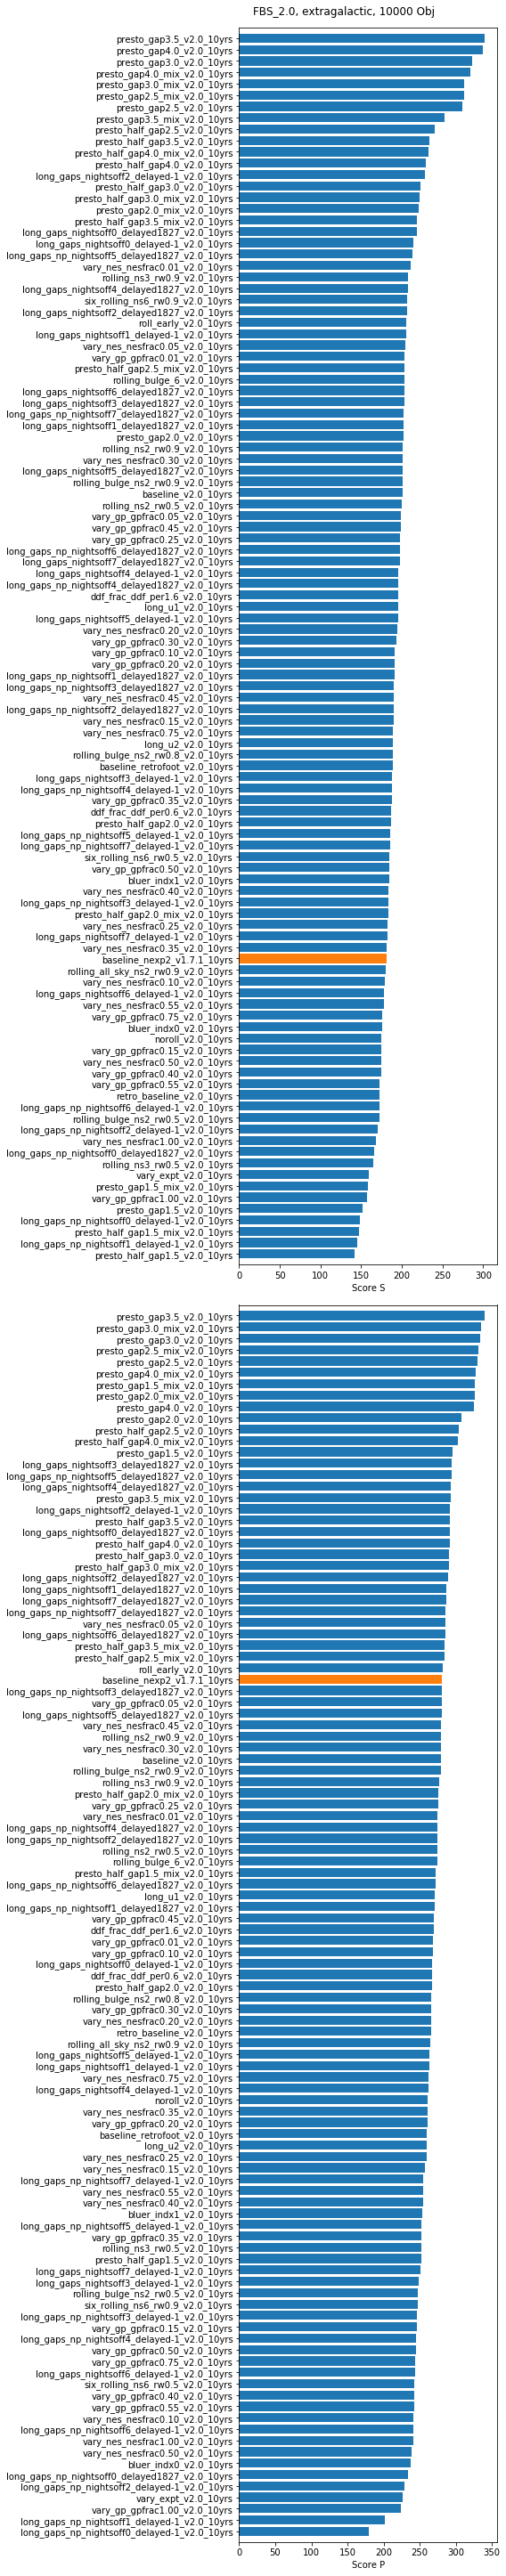

In [121]:
plotScoreChart(resultDict, overlay=True)

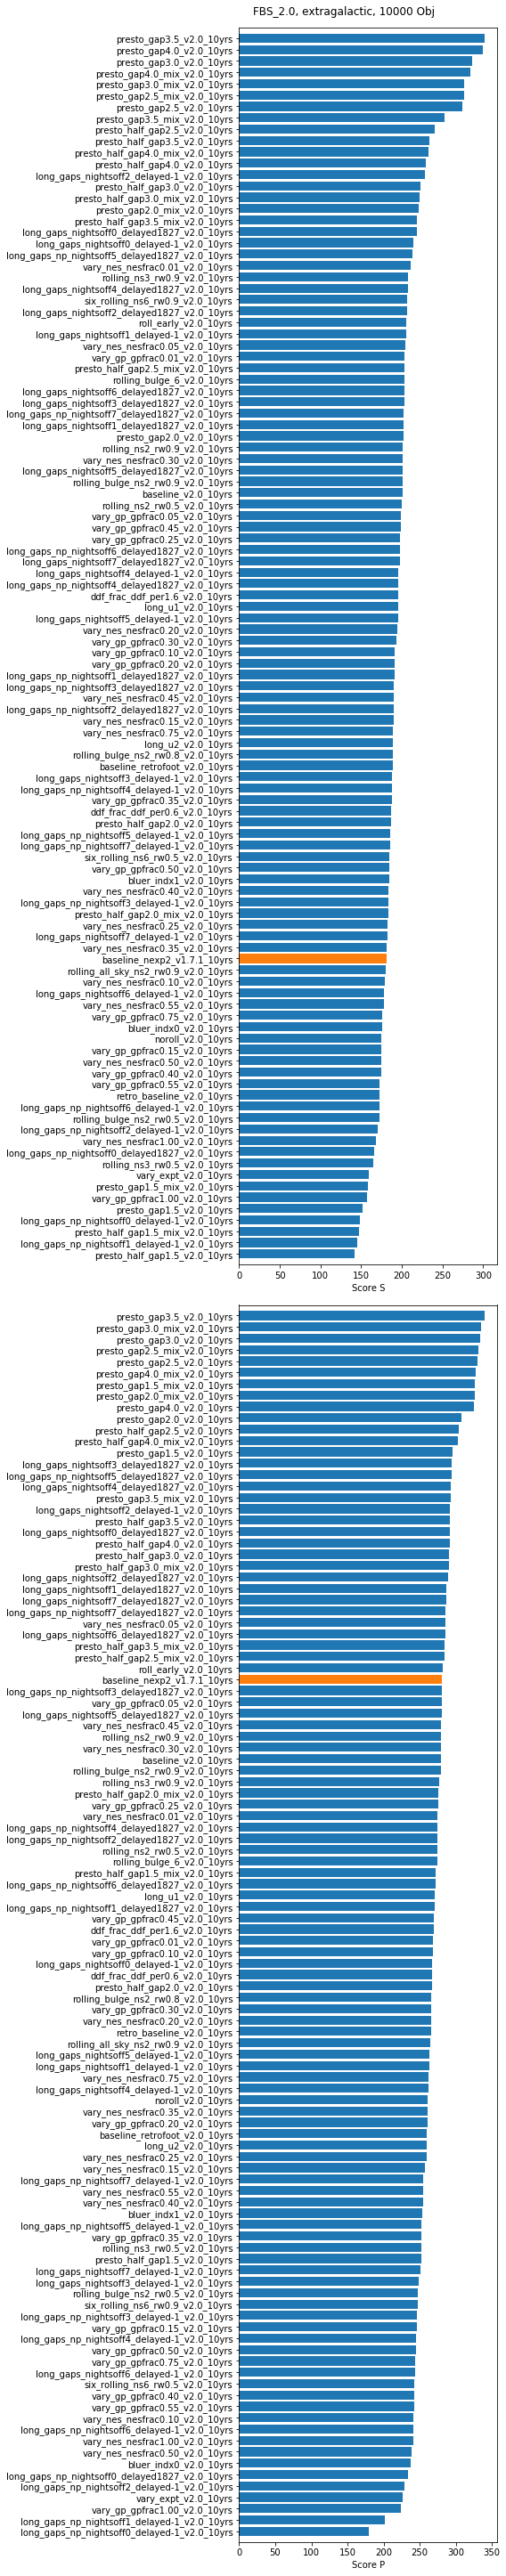

In [111]:
### Extragalactic Datacube, 1000 Obj, 2.0
fig, ax = plt.subplots(2,1, figsize=(8,40))
fig.text(0.5,1,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['sky region'], resultDict['KNe No']), fontsize=12)
# print(resultDict['score S'])
# print(resultDict['score P'])
# print(resultDict['detects'])
ind = np.argsort(resultDict['score S'])
ax[0].barh(resultDict['run names'][ind], resultDict['score S'][ind])
ax[0].barh(resultDict['run names'][ind], overlayS[ind])
ax[0].set_xlabel('Score S')
ax[0].margins(y=0.005)
ind = np.argsort(resultDict['score P'])
ax[1].barh(resultDict['run names'][ind], resultDict['score P'][ind])
ax[1].barh(resultDict['run names'][ind], overlayP[ind])
ax[1].set_xlabel('Score P')
ax[1].margins(y=0.005)
fig.tight_layout()

[191. 200. 207. 189. 218. 203. 219. 175. 203. 173. 178. 203. 194. 221.
 229. 201. 188. 175. 300. 188. 180. 182. 148. 175. 201. 182. 189. 186.
 214. 175. 205. 183. 203. 188. 190. 199. 193. 196. 166. 183. 206. 213.
 204. 168. 181. 189. 198. 252. 176. 211. 190. 228. 186. 195. 202. 184.
 179. 277. 172. 145. 178. 158. 284. 206. 152. 198. 184. 142. 198. 203.
 173. 191. 207. 165. 201. 190. 187. 276. 201. 202. 187. 190. 240. 183.
 181. 274. 189. 201. 184. 191. 176. 196. 159. 223. 205. 173. 196. 286.
 157. 233. 147. 170. 199. 195. 202. 302. 234. 222.]
[268.31760368 274.24051271 276.91374506 259.30440687 291.39836137
 268.7082185  284.43247828 246.22399674 294.31543257 265.23711785
 254.8439598  285.49037879 265.35336805 326.70791725 291.34199735
 279.12153901 245.46794225 261.29282283 325.57198778 248.06996312
 265.05017493 251.54847945 180.10520889 238.13354368 280.37759995
 259.203295   259.97809045 255.30988871 267.44314196 242.8268296
 281.69460668 275.3675677  274.22192793 252.40107806 280

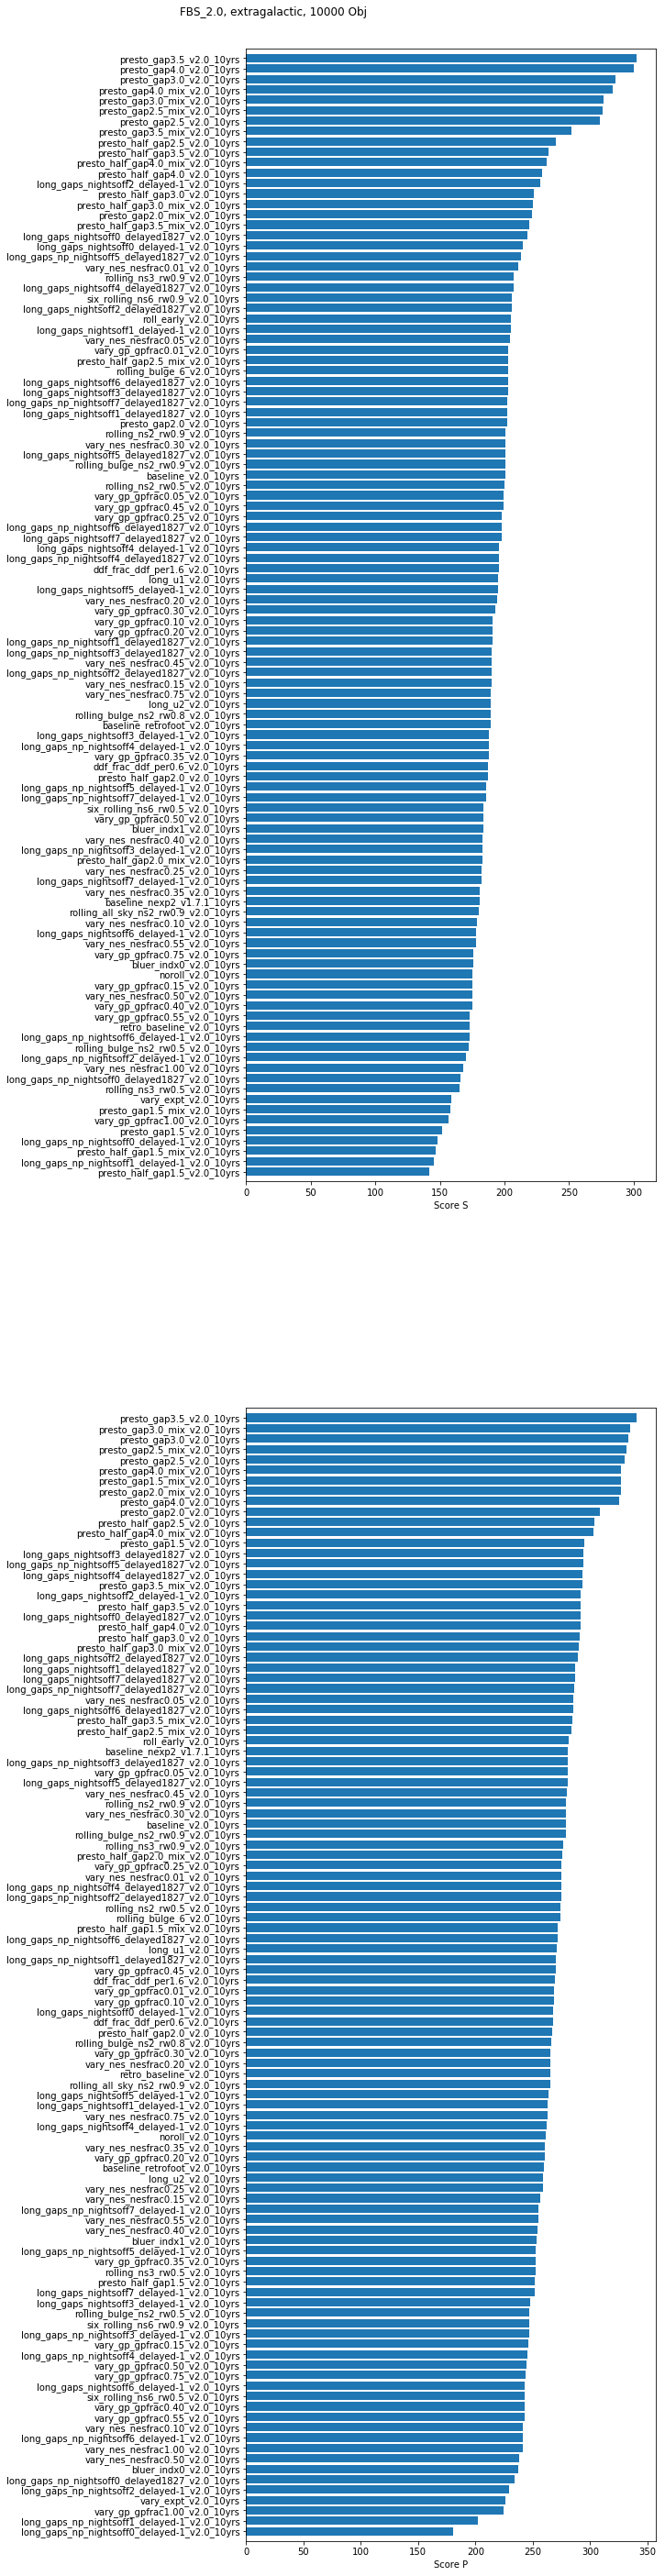

In [99]:
### Extragalactic Datacube, 1000 Obj, 2.0
fig, ax = plt.subplots(2,1, figsize=(8,50))
fig.text(0,0.89,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['sky region'], resultDict['KNe No']), fontsize=12)
print(resultDict['score S'])
print(resultDict['score P'])
print(resultDict['detects'])
ind = np.argsort(resultDict['score S'])
ax[0].barh(resultDict['run names'][ind], resultDict['score S'][ind])
ax[0].set_xlabel('Score S')
ax[0].margins(y=0.005)
ind = np.argsort(resultDict['score P'])
ax[1].barh(resultDict['run names'][ind], resultDict['score P'][ind])
ax[1].set_xlabel('Score P')
ax[1].margins(y=0.005)

In [ ]:
tight_layout = True


[191. 200. 207. 189. 218. 203. 219. 175. 203. 173. 178. 203. 194. 221.
 229. 201. 188. 175. 300. 188. 180. 182. 148. 175. 201. 182. 189. 186.
 214. 175. 205. 183. 203. 188. 190. 199. 193. 196. 166. 183. 206. 213.
 204. 168. 181. 189. 198. 252. 176. 211. 190. 228. 186. 195. 202. 184.
 179. 277. 172. 145. 178. 158. 284. 206. 152. 198. 184. 142. 198. 203.
 173. 191. 207. 165. 201. 190. 187. 276. 201. 202. 187. 190. 240. 183.
 181. 274. 189. 201. 184. 191. 176. 196. 159. 223. 205. 173. 196. 286.
 157. 233. 147. 170. 199. 195. 202. 302. 234. 222.]
[268.31760368 274.24051271 276.91374506 259.30440687 291.39836137
 268.7082185  284.43247828 246.22399674 294.31543257 265.23711785
 254.8439598  285.49037879 265.35336805 326.70791725 291.34199735
 279.12153901 245.46794225 261.29282283 325.57198778 248.06996312
 265.05017493 251.54847945 180.10520889 238.13354368 280.37759995
 259.203295   259.97809045 255.30988871 267.44314196 242.8268296
 281.69460668 275.3675677  274.22192793 252.40107806 280

Text(0.5, 0, 'Score P')

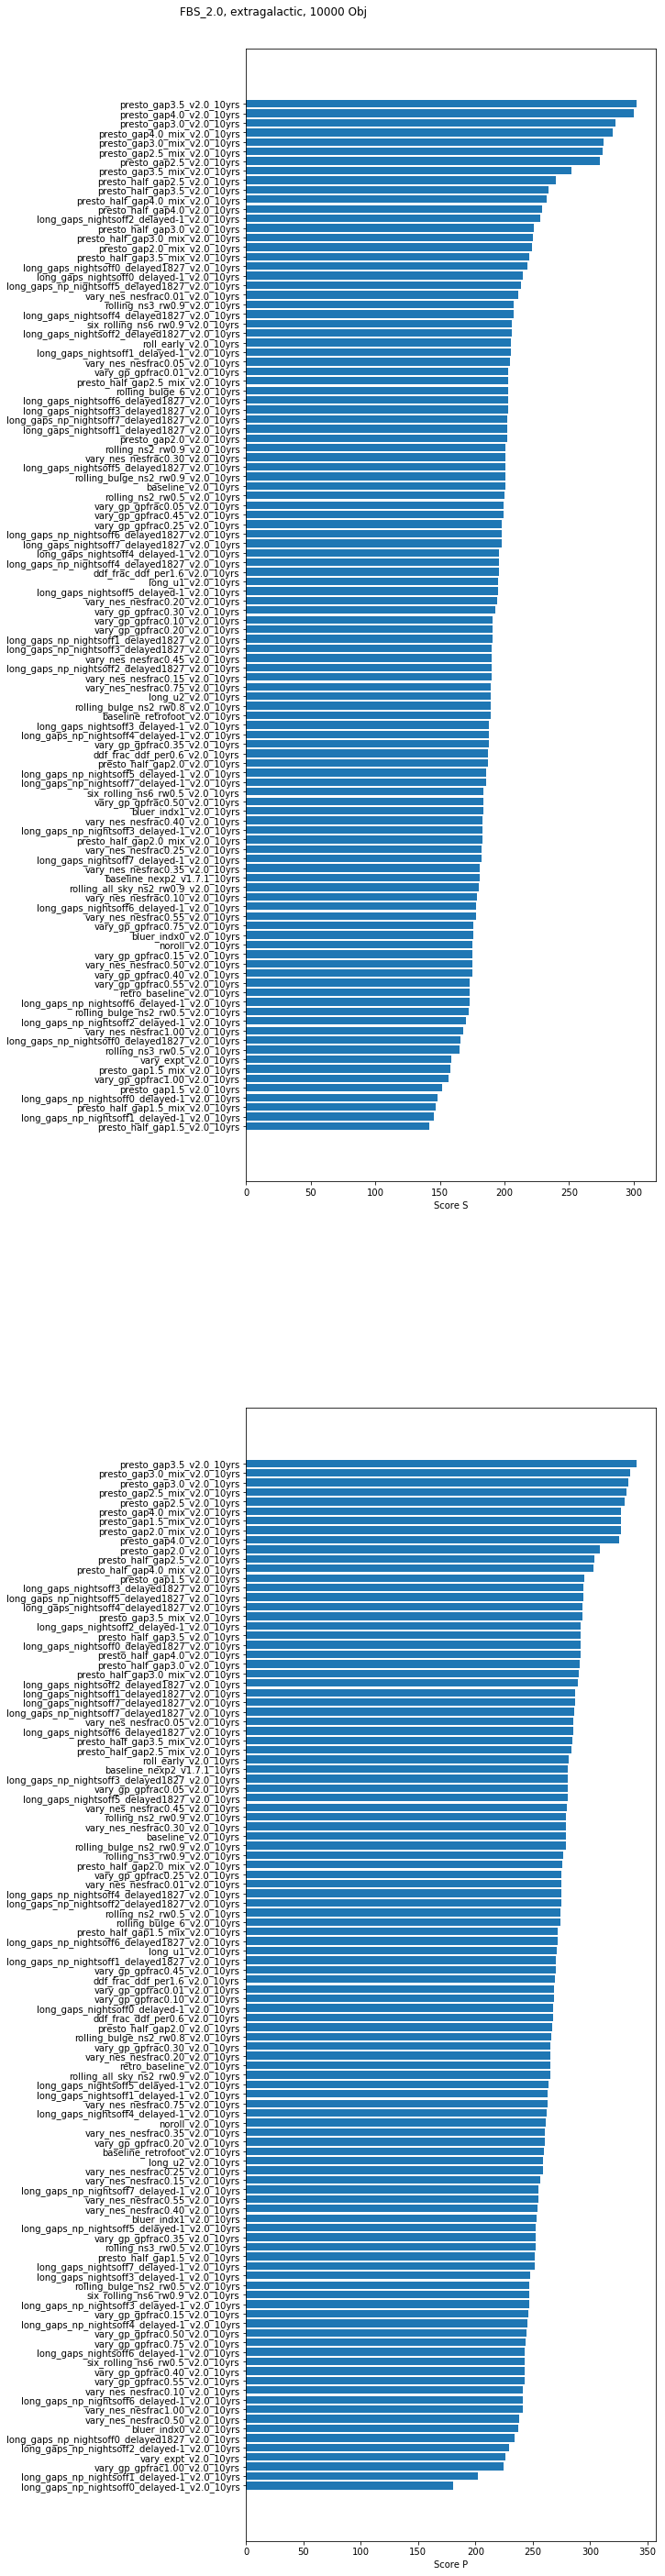

In [35]:
### Extragalactic Datacube, 1000 Obj, 2.0
fig, ax = plt.subplots(2,1, figsize=(8,50))
fig.text(0,0.89,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['sky region'], resultDict['KNe No']), fontsize=12)
print(resultDict['score S'])
print(resultDict['score P'])
print(resultDict['detects'])
ind = np.argsort(resultDict['score S'])
ax[0].barh(resultDict['run names'][ind], resultDict['score S'][ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(resultDict['score P'])
ax[1].barh(resultDict['run names'][ind], resultDict['score P'][ind])
ax[1].set_xlabel('Score P')

[15. 15. 22. 13. 25. 21. 20. 17. 21. 15. 17. 23. 16. 16. 23. 18. 19. 12.
 27. 14. 17. 18. 14. 16. 20. 21. 20. 23. 20. 12. 14. 22. 17. 16. 21. 15.
 19. 16. 19. 24. 17. 23. 25. 23. 15. 15. 20. 33. 13. 18. 17. 13. 16. 15.
 17. 10. 15. 35. 15. 13. 20. 11. 26. 21. 11. 25. 12. 13. 15. 25. 15. 17.
 20. 19. 21. 17. 13. 22. 21. 21. 17. 20. 16. 17. 18. 17.  9. 21. 19. 23.
 15. 19. 19. 24. 14. 14. 21. 29. 10. 25. 12. 15. 16. 16. 16. 24. 24. 22.]
[22.00395377 20.18810129 25.50173324 18.72852225 28.81429043 26.02660203
 24.51476295 20.98267911 25.87836209 24.58857106 23.09673398 30.17113473
 21.51848033 28.25320058 30.30199197 25.5662461  26.78555002 17.89272913
 31.94300485 19.33494647 22.03745164 24.71568424 16.40349711 25.06011273
 24.58310726 26.40588264 26.29802959 29.26082996 23.77023409 20.44851326
 17.83476193 36.72054793 24.45164458 22.70024293 26.52374169 20.636713
 25.73265895 21.87815739 22.55518571 29.72210465 19.37374334 28.32635614
 31.76284912 30.34407043 24.7873252  23.87619215 24.

Text(0.5, 0, 'Score P')

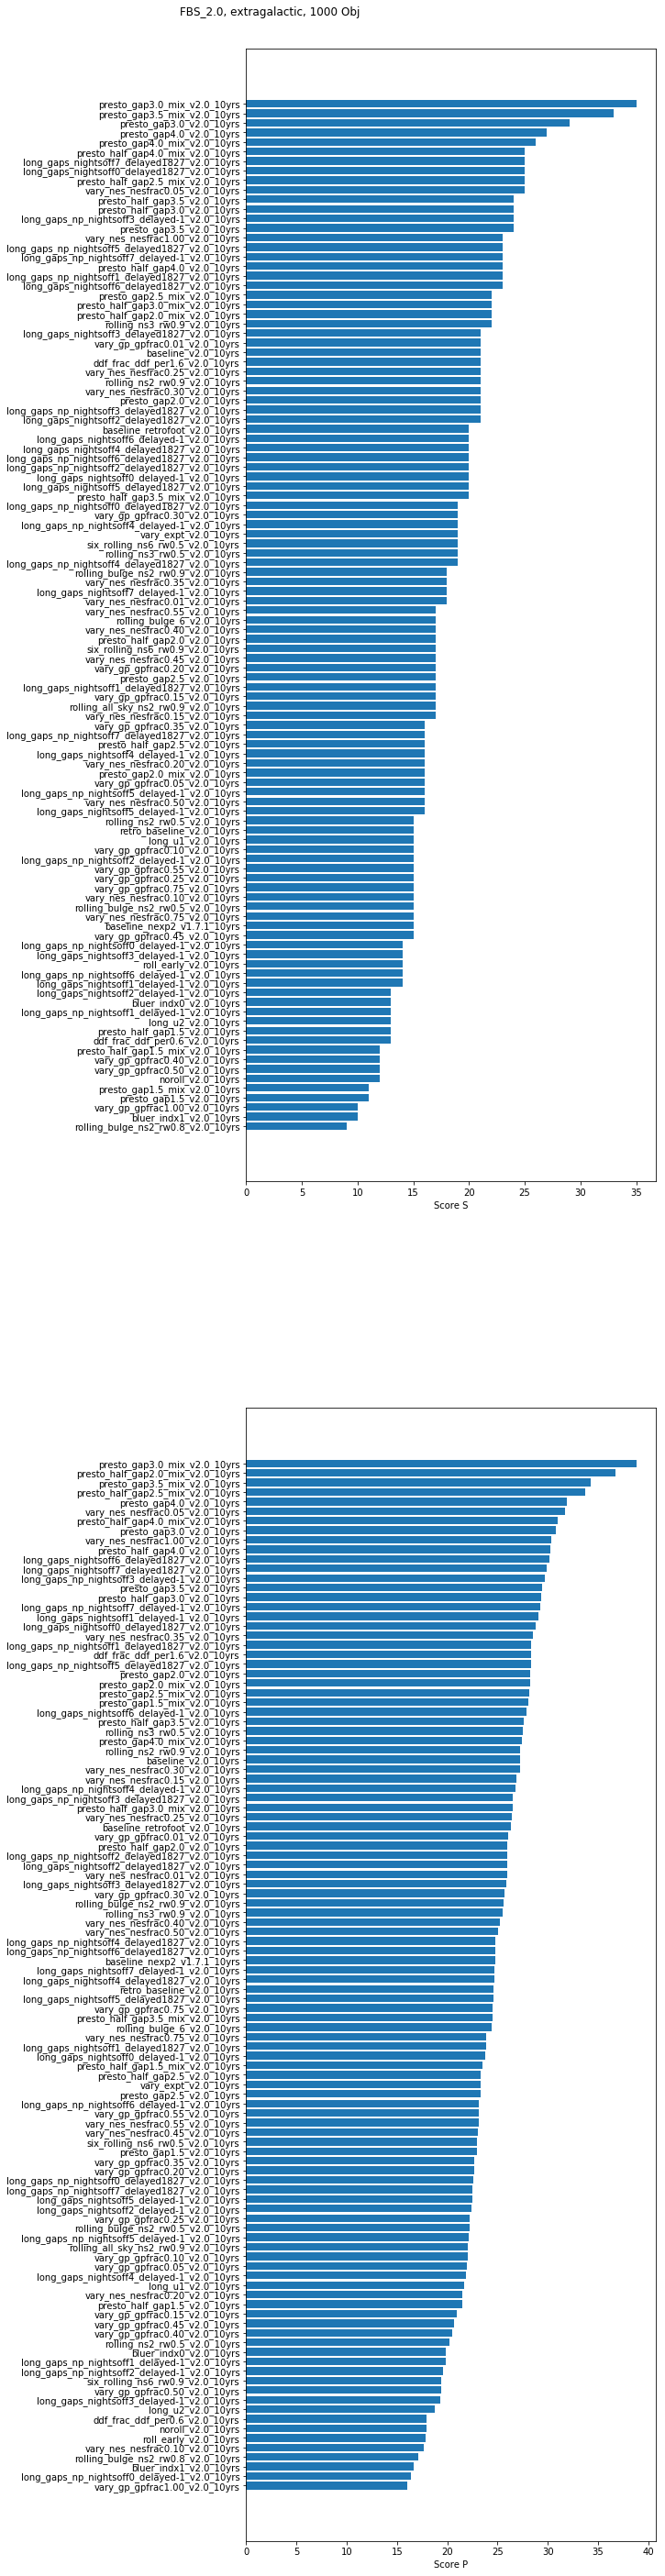

In [23]:
### Extragalactic Datacube, 1000 Obj, 2.0
fig, ax = plt.subplots(2,1, figsize=(8,50))
fig.text(0,0.89,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['sky region'], resultDict['KNe No']), fontsize=12)
print(resultDict['score S'])
print(resultDict['score P'])
print(resultDict['detects'])
ind = np.argsort(resultDict['score S'])
ax[0].barh(resultDict['run names'][ind], resultDict['score S'][ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(resultDict['score P'])
ax[1].barh(resultDict['run names'][ind], resultDict['score P'][ind])
ax[1].set_xlabel('Score P')

[194. 161.  85. 165. 168. 172. 181. 156. 178. 166.  85. 159. 178. 155.
 160. 152. 169. 174. 165. 106. 197. 171. 161.  98. 183.  98. 183. 189.
 180. 155. 168.  92. 172. 108. 184.  96. 163. 161.  85. 167. 189.  94.
  98. 168. 156.  98. 178. 103. 147. 103. 186. 103. 181. 172.  91. 165.
  84. 199.  94. 164. 159. 193. 140. 159. 189.  98. 208. 161. 141. 119.
 172. 177. 101. 166.]
[268.77642687 251.35522758 207.33779199 251.06399911 260.58858167
 264.7573939  274.50284327 276.8498736  245.50803575 251.08165707
 225.33639054 239.39775796 248.68452769 244.39280325 265.50325546
 216.84024999 270.03817223 266.69190296 256.24428667 218.77366714
 278.90784395 254.81255178 251.35522758 230.02435628 275.65926388
 228.39300099 264.26016912 285.042759   255.62191944 246.80726041
 267.65385236 221.41792363 258.40515721 251.95248209 278.58883924
 218.75234607 253.54145375 251.35522758 219.06049233 257.19285028
 270.13996095 225.82965878 241.51349585 260.12886565 248.62942126
 228.79154199 259.68000551 23

Text(0.5, 0, 'Score P')

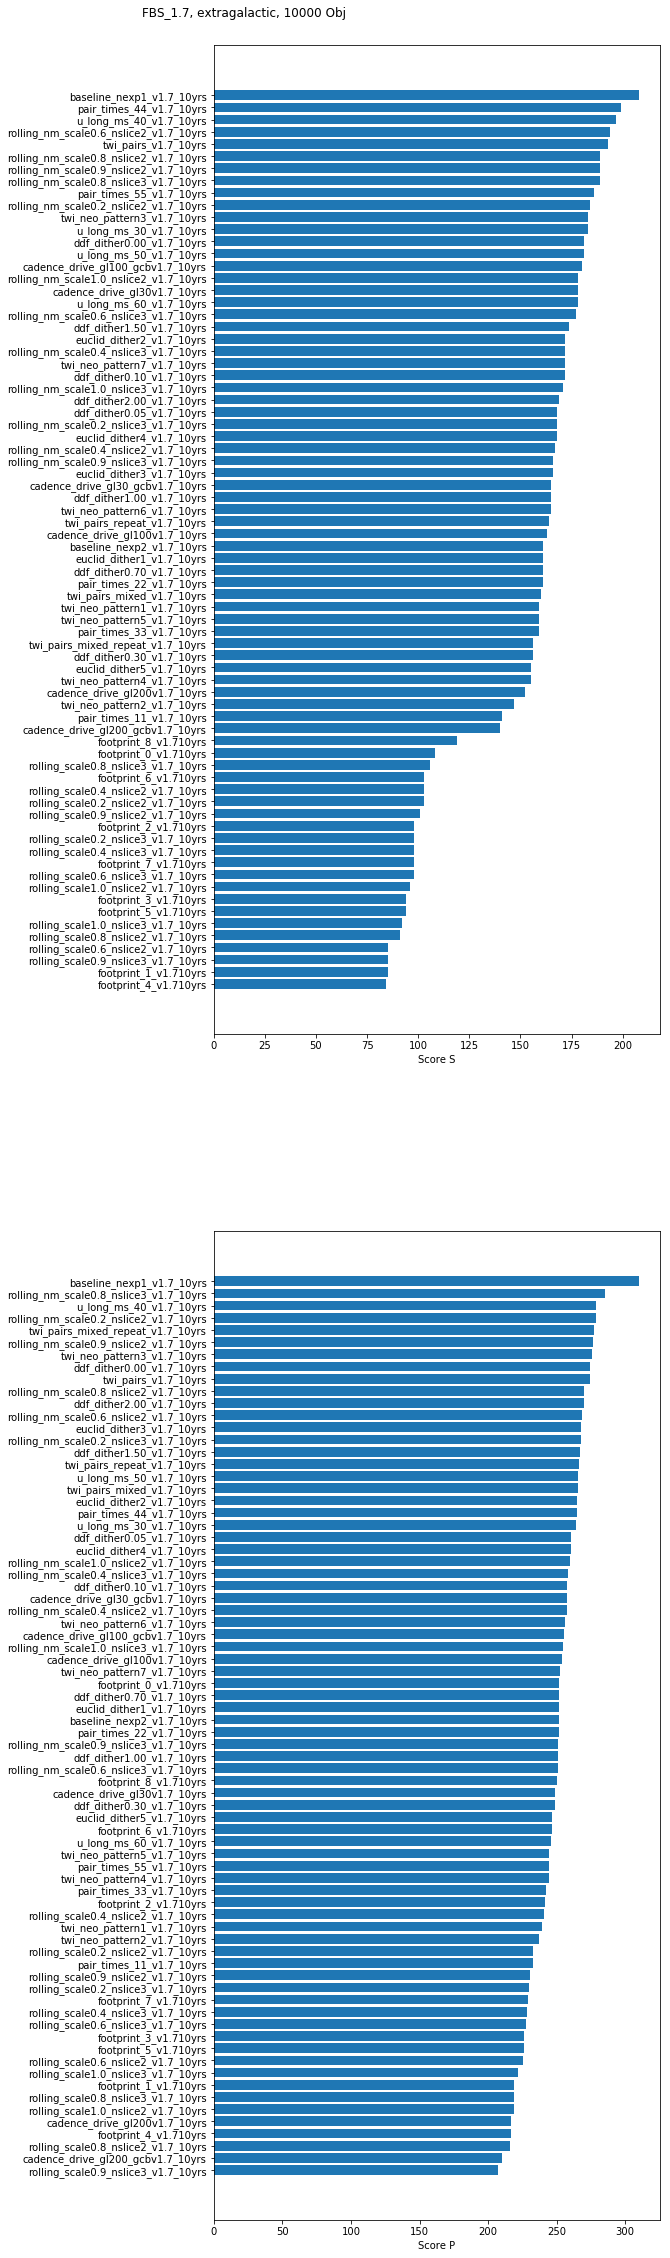

In [67]:
### Extragalactic Datacube, 10000 Obj, 1.7
fig, ax = plt.subplots(2,1, figsize=(8,40))
fig.text(0,0.89,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['skyregion'], resultDict['KNeNo']), fontsize=12)
print(scoreS)
print(scoreP)
print(detects)
ind = np.argsort(scoreS)
ax[0].barh(runNames[ind], scoreS[ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(scoreP)
ax[1].barh(runNames[ind], scoreP[ind])
ax[1].set_xlabel('Score P')

[19. 13.  7.  9. 12. 15. 20. 16. 16. 11.  8. 12. 23. 13. 18. 18. 15. 22.
 15.  6. 20. 20. 13.  9. 17. 10. 14. 15.  7. 13. 15.  6. 16.  5. 16.  6.
 12. 13.  9. 19. 19. 14. 11. 17. 13. 10. 17. 14. 17.  4. 22. 10. 17. 14.
 11. 15.  6. 11. 14. 10. 16. 14. 14. 22. 12. 11. 17. 13. 15.  3. 13. 12.
  9. 12.]
[27.28939458 24.32664642 21.57518251 15.81094537 19.65158023 21.66784347
 25.8215888  25.66870071 24.27746967 18.6902103  19.12424488 22.29738967
 30.96205199 21.54833489 30.38393474 21.94082816 21.55037992 30.07937743
 22.39971878 19.89005178 26.94462812 25.27048424 24.32664642 22.2202243
 24.50861859 22.07755606 20.00574178 21.5944598  14.97962436 18.19473396
 23.05024186 21.18021188 28.55172233 19.67851475 26.21247905 17.55977739
 17.4745363  24.32664642 23.46160706 27.72606783 26.11071668 24.86875153
 20.68156147 24.30185144 19.04119308 23.02665196 27.28011267 29.44070945
 21.71247632 16.38395459 26.49790913 24.22088384 24.08949697 20.92104778
 20.67973234 20.34320074 19.98319847 17.49

Text(0.5, 0, 'Score P')

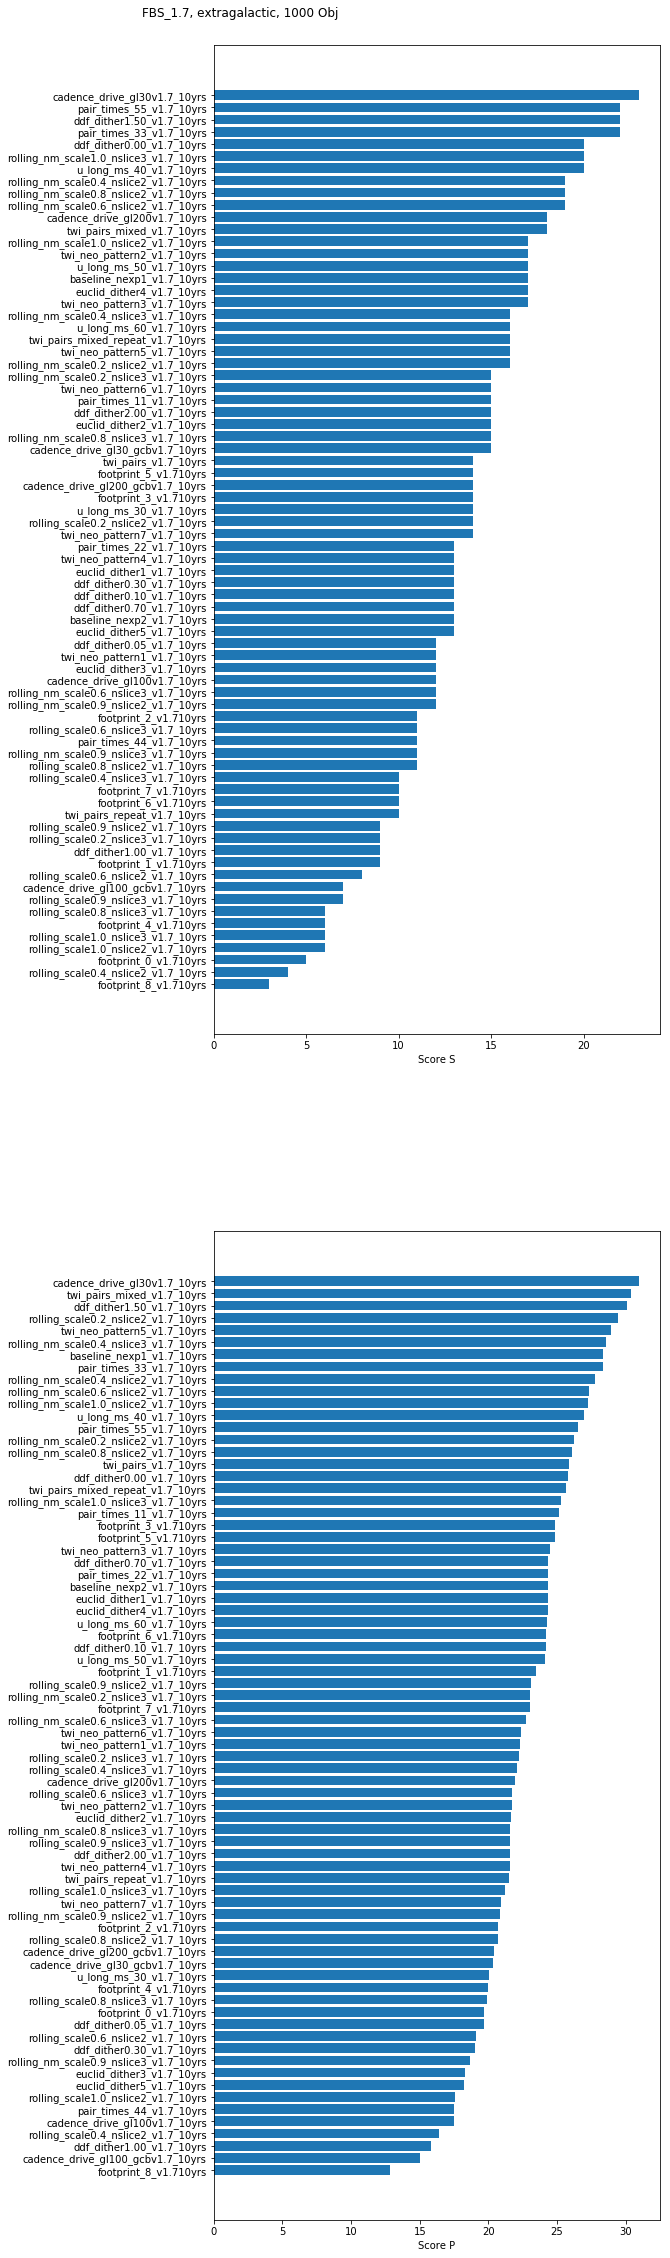

In [57]:
### Extragalactic Datacube, 1000 Obj, 1.7
fig, ax = plt.subplots(2,1, figsize=(8,40))
fig.text(0,0.89,'{}, {}, {} Obj'.format(resultDict['survey'], resultDict['skyregion'], resultDict['KNeNo']), fontsize=12)
print(scoreS)
print(scoreP)
print(detects)
ind = np.argsort(scoreS)
ax[0].barh(runNames[ind], scoreS[ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(scoreP)
ax[1].barh(runNames[ind], scoreP[ind])
ax[1].set_xlabel('Score P')

[29. 23. 18. 23. 18. 11. 19. 14. 14. 15.]
[34.92268953 30.12137768 22.44600219 27.63479751 26.45492601 24.68602899
 24.43032186 19.20668881 19.84022155 24.7873252 ]
[51. 52. 36. 44. 45. 47. 40. 31. 36. 46.]


Text(0.5, 0, 'Score P')

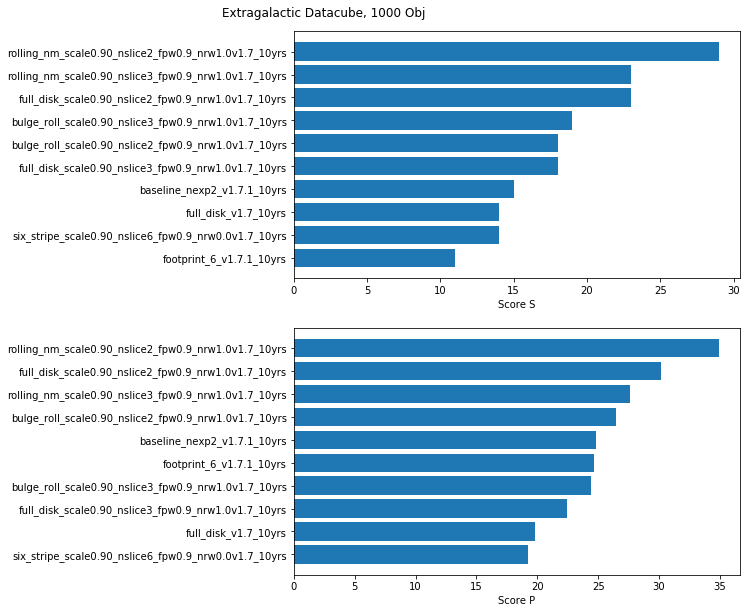

In [120]:
### Extragalactic Datacube, 1000 Obj
fig, ax = plt.subplots(2,1, figsize=(8,10))
fig.text(0,0.9,'Extragalactic Datacube, 1000 Obj', fontsize=12)
print(scoreS)
print(scoreP)
print(detects)
ind = np.argsort(scoreS)
ax[0].barh(runNames[ind], scoreS[ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(scoreP)
ax[1].barh(runNames[ind], scoreP[ind])
ax[1].set_xlabel('Score P')

[219. 182. 196. 211. 190.  97. 197. 203. 187. 181.]
[283.21871148 238.50902341 253.49597668 268.79254805 241.96387384
 219.56105644 257.35804962 265.43804458 281.57195137 280.72658137]
[481. 430. 419. 441. 469. 485. 432. 412. 481. 515.]


Text(0.5, 0, 'Score P')

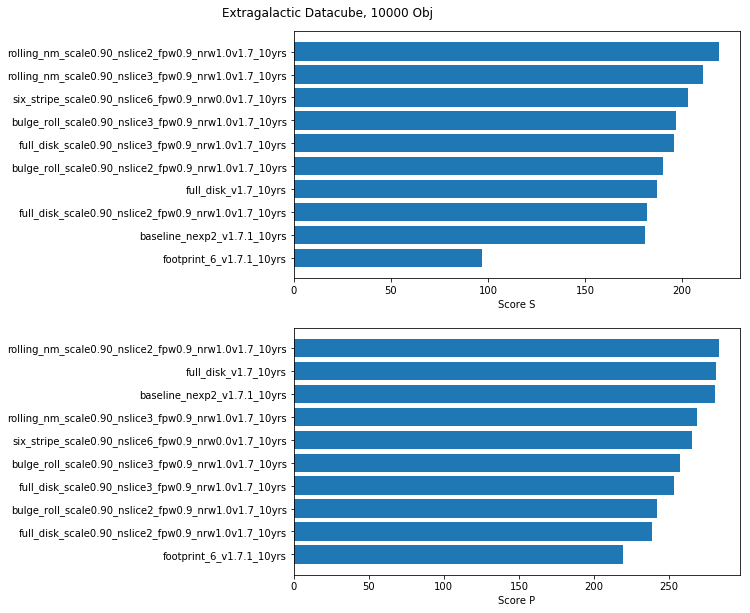

In [125]:
### Extragalactic Datacube, 10000 Obj
fig, ax = plt.subplots(2,1, figsize=(8,10))
fig.text(0,0.9,'Extragalactic Datacube, 10000 Obj', fontsize=12)
print(scoreS)
print(scoreP)
print(detects)
ind = np.argsort(scoreS)
ax[0].barh(runNames[ind], scoreS[ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(scoreP)
ax[1].barh(runNames[ind], scoreP[ind])
ax[1].set_xlabel('Score P')

[219. 182. 196. 211. 190.  97. 197. 203. 187. 181.]
[481. 430. 419. 441. 469. 485. 432. 412. 481. 515.]


<BarContainer object of 10 artists>

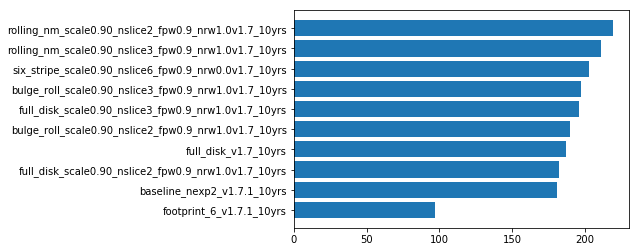

In [31]:
### S for Uniform Datacube, 10000 Obj

print(scores)
print(detects)
ind = np.argsort(scores)
plt.barh(runNames[ind], scores[ind])

[29. 23. 18. 23. 18. 11. 19. 14. 14. 15.]
[32.40167    28.19954589 21.73517572 25.92905268 23.5312314  20.04214879
 22.40844153 17.53299832 18.57561543 21.70363059]
[51. 52. 36. 44. 45. 47. 40. 31. 36. 46.]


Text(0.5, 0, 'Score P')

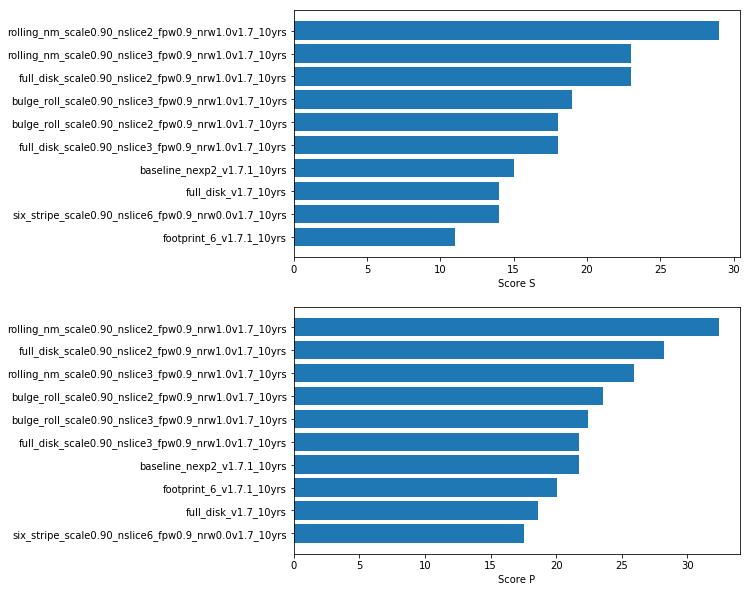

In [99]:
### Uniform Datacube, 1000 Obj
fig, ax = plt.subplots(2,1, figsize=(8,10))
print(scoreS)
print(scoreP)
print(detects)
ind = np.argsort(scoreS)
ax[0].barh(runNames[ind], scoreS[ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(scoreP)
ax[1].barh(runNames[ind], scoreP[ind])
ax[1].set_xlabel('Score P')

In [24]:
with open('Score_Results/FBS_2.0_extragalactic_1000_0203_0209.pkl', 'rb') as f:
    resultDict_load = pickle.load(f)

[15. 15. 22. 13. 25. 21. 20. 17. 21. 15. 17. 23. 16. 16. 23. 18. 19. 12.
 27. 14. 17. 18. 14. 16. 20. 21. 20. 23. 20. 12. 14. 22. 17. 16. 21. 15.
 19. 16. 19. 24. 17. 23. 25. 23. 15. 15. 20. 33. 13. 18. 17. 13. 16. 15.
 17. 10. 15. 35. 15. 13. 20. 11. 26. 21. 11. 25. 12. 13. 15. 25. 15. 17.
 20. 19. 21. 17. 13. 22. 21. 21. 17. 20. 16. 17. 18. 17.  9. 21. 19. 23.
 15. 19. 19. 24. 14. 14. 21. 29. 10. 25. 12. 15. 16. 16. 16. 24. 24. 22.]
[22.00395377 20.18810129 25.50173324 18.72852225 28.81429043 26.02660203
 24.51476295 20.98267911 25.87836209 24.58857106 23.09673398 30.17113473
 21.51848033 28.25320058 30.30199197 25.5662461  26.78555002 17.89272913
 31.94300485 19.33494647 22.03745164 24.71568424 16.40349711 25.06011273
 24.58310726 26.40588264 26.29802959 29.26082996 23.77023409 20.44851326
 17.83476193 36.72054793 24.45164458 22.70024293 26.52374169 20.636713
 25.73265895 21.87815739 22.55518571 29.72210465 19.37374334 28.32635614
 31.76284912 30.34407043 24.7873252  23.87619215 24.

Text(0.5, 0, 'Score P')

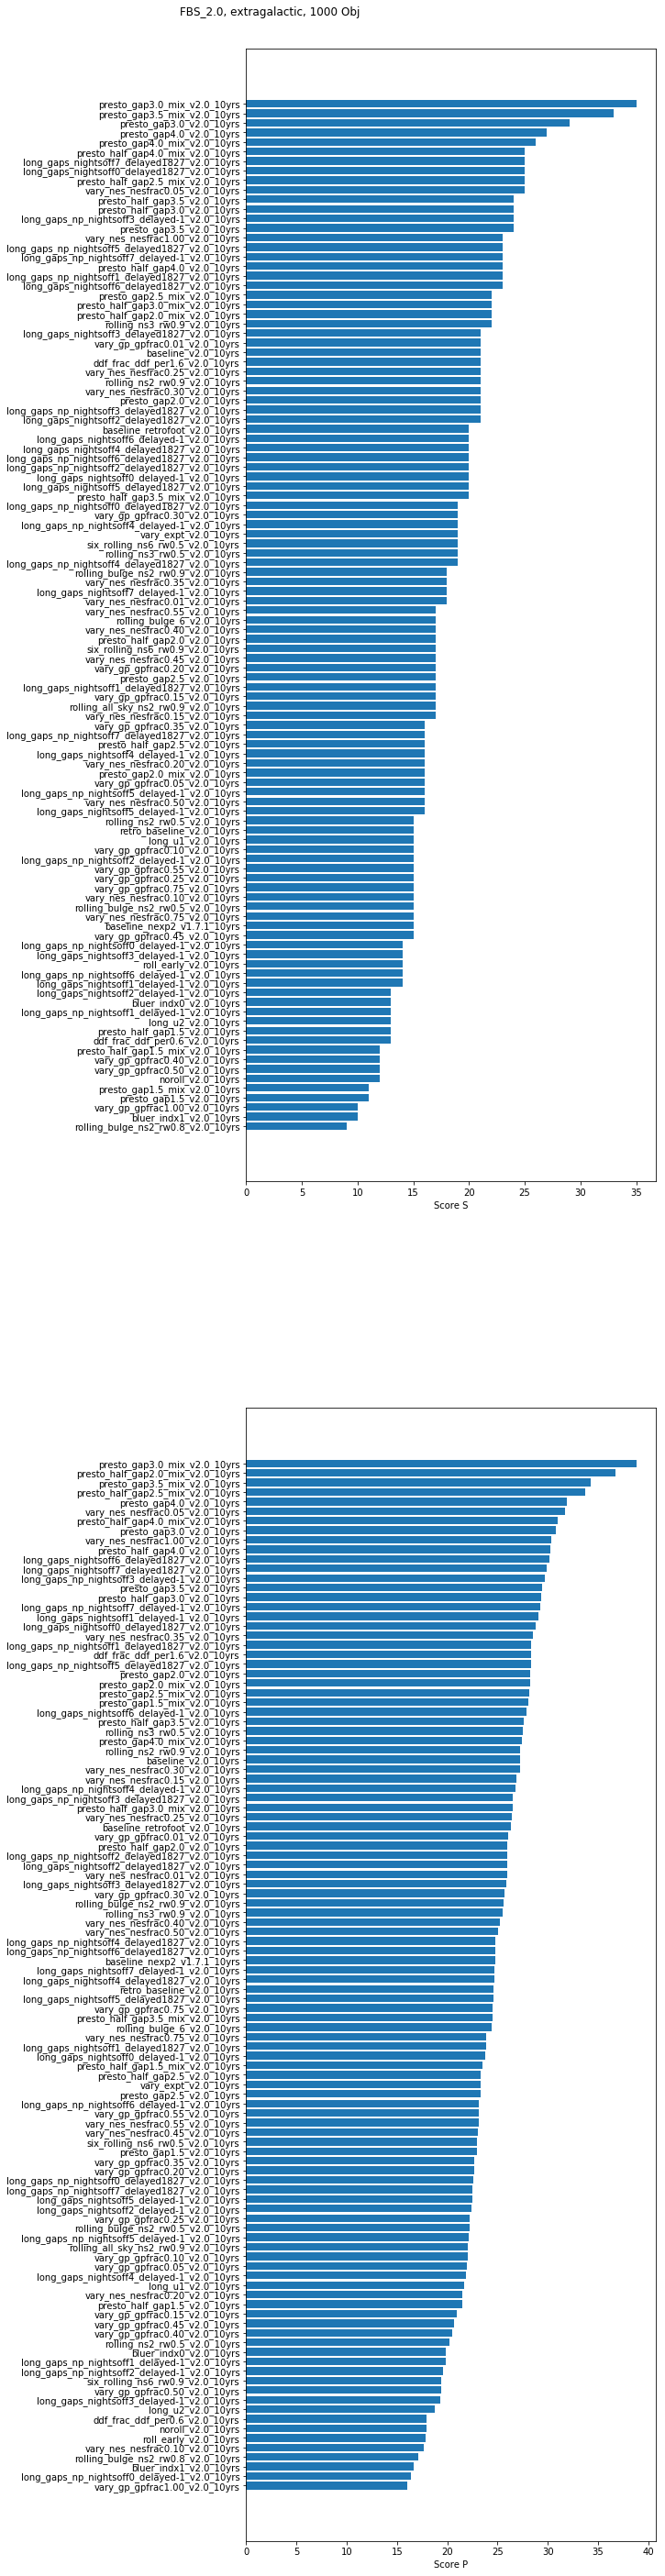

In [25]:
### Extragalactic Datacube, 1000 Obj, 2.0
fig, ax = plt.subplots(2,1, figsize=(8,50))
fig.text(0,0.89,'{}, {}, {} Obj'.format(resultDict_load['survey'], resultDict_load['sky region'], resultDict_load['KNe No']), fontsize=12)
print(resultDict_load['score S'])
print(resultDict_load['score P'])
print(resultDict_load['detects'])
ind = np.argsort(resultDict_load['score S'])
ax[0].barh(resultDict_load['run names'][ind], resultDict_load['score S'][ind])
ax[0].set_xlabel('Score S')
ind = np.argsort(resultDict_load['score P'])
ax[1].barh(resultDict_load['run names'][ind], resultDict_load['score P'][ind])
ax[1].set_xlabel('Score P')